In [1]:
import os
import numpy as np
import scipy as sp
from KRR_Functions import *
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
rng = np.random.RandomState(0)

# Load data.

In [2]:
# setup
SIM_NO = 201            # total number of data points
STR_PREF = '/Users/jonpvandermause/AP275/Al_Data/Store/'

pos = []
ens = []
fours = []

for n in range(SIM_NO):
    # load arrays
    en_curr = np.reshape(np.load(STR_PREF+'en_store/energy'+str(n)+'.npy'),(1))[0]
    pos_curr = np.load(STR_PREF+'pos_store/pos'+str(n)+'.npy')
    four_curr = np.load(STR_PREF+'four_store/four'+str(n)+'.npy')
    
    # store arrays
    ens.append(en_curr)
    pos_curr = pos_curr.flatten()
    pos.append(pos_curr)
    fours.append(four_curr)

# convert to np arrays
ens = np.array(ens)
pos = np.array(pos)
fours = np.abs(np.array(fours))

# KS

In [3]:
import warnings
warnings.filterwarnings("ignore")
kcal_conv = 0.043


 Current training set size: 5
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=0.093260334688322,
      kernel='rbf', kernel_params=None)


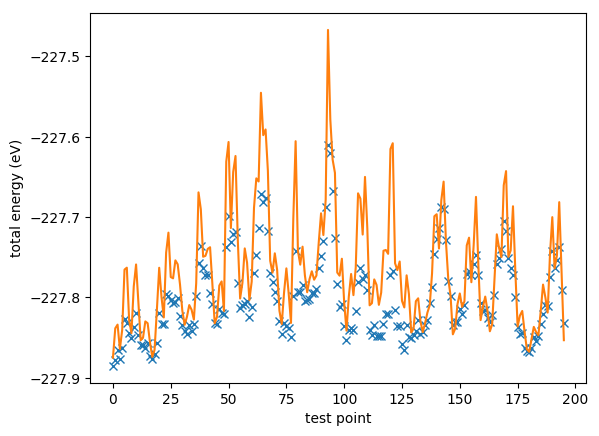

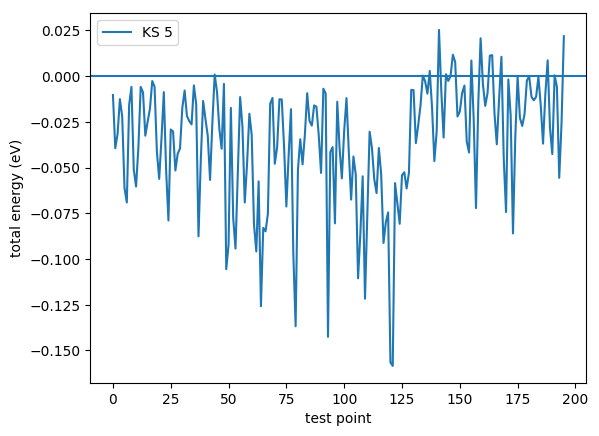

The KRR max error in kcal/mol is 3.6851985291726783
The KRR MAE in kcal/mol is 0.869312440174981

 Current training set size: 7
KernelRidge(alpha=2.511886431509572e-09, coef0=1, degree=3,
      gamma=0.1519911082952934, kernel='rbf', kernel_params=None)


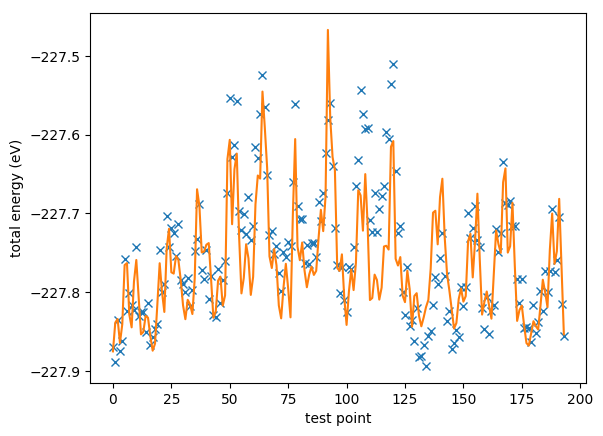

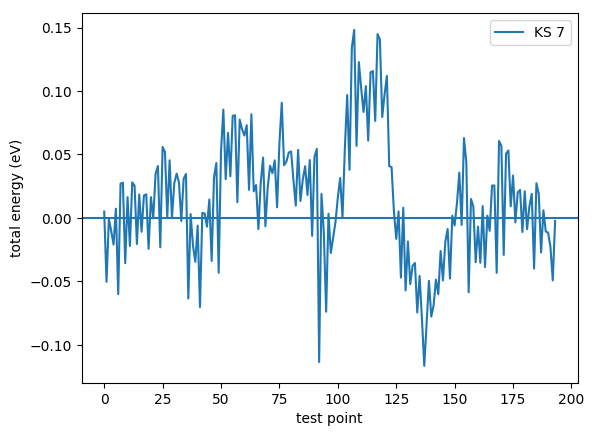

The KRR max error in kcal/mol is 3.4440359489081427
The KRR MAE in kcal/mol is 0.9106214355106694

 Current training set size: 10
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=0.13219411484660293,
      kernel='rbf', kernel_params=None)


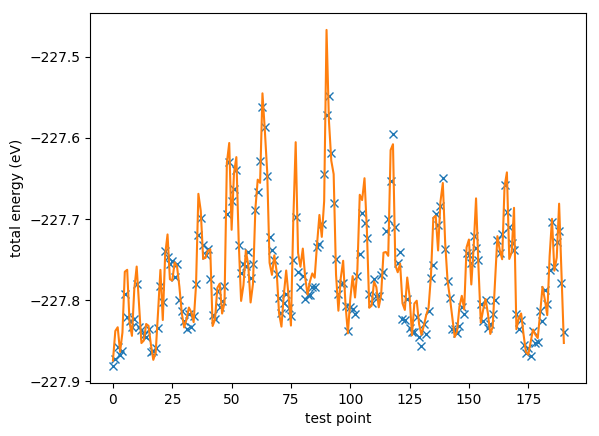

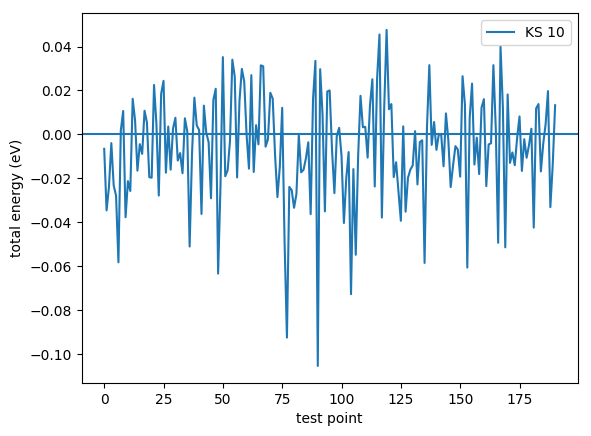

The KRR max error in kcal/mol is 2.4533731156672074
The KRR MAE in kcal/mol is 0.43863366226814215

 Current training set size: 15
KernelRidge(alpha=1.5848931924611107e-05, coef0=1, degree=3,
      gamma=0.14174741629268056, kernel='rbf', kernel_params=None)


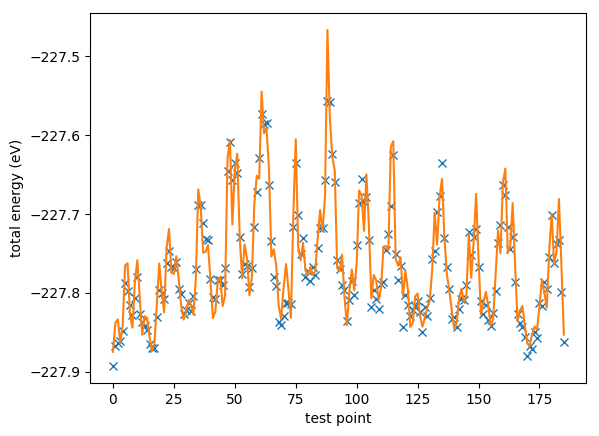

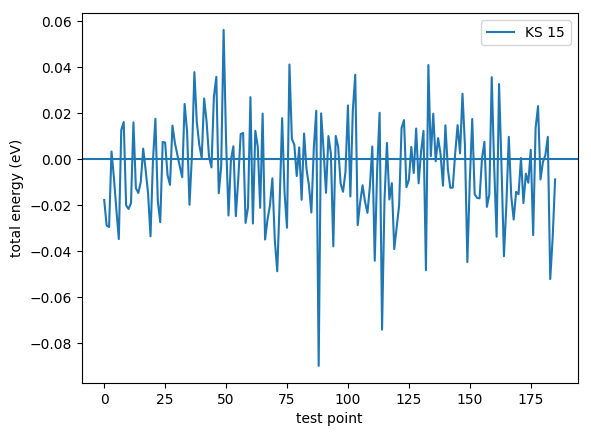

The KRR max error in kcal/mol is 2.094946856033175
The KRR MAE in kcal/mol is 0.3950541296215408

 Current training set size: 75
KernelRidge(alpha=2.511886431509572e-09, coef0=1, degree=3,
      gamma=0.16297508346206444, kernel='rbf', kernel_params=None)


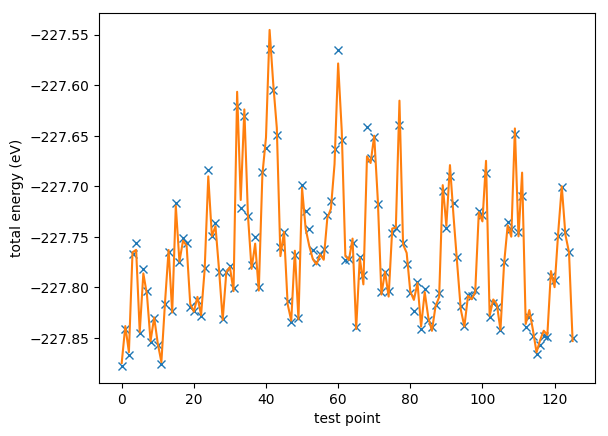

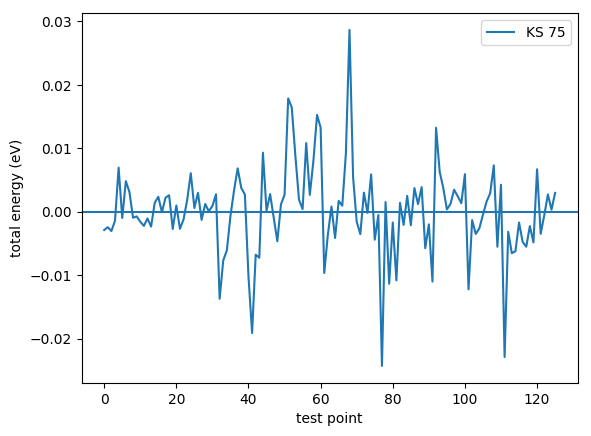

The KRR max error in kcal/mol is 0.6657080106211113
The KRR MAE in kcal/mol is 0.11012248912834303

 Current training set size: 133
KernelRidge(alpha=2.511886431509572e-09, coef0=1, degree=3,
      gamma=0.37649358067924676, kernel='rbf', kernel_params=None)


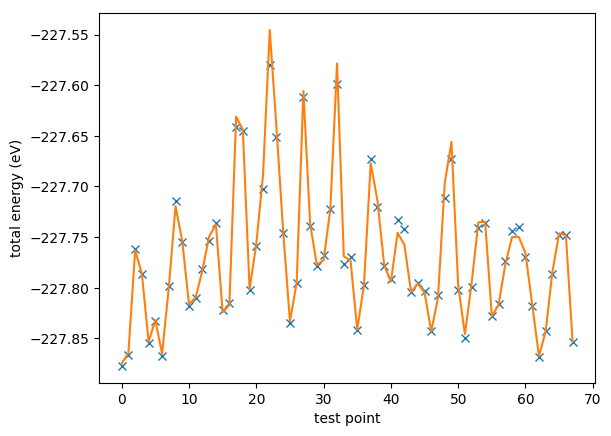

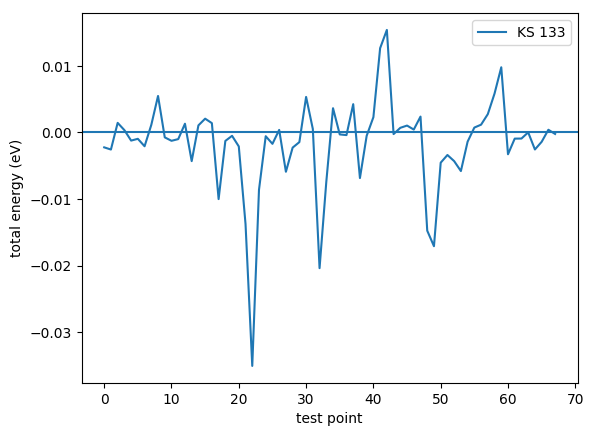

The KRR max error in kcal/mol is 0.8153247884347049
The KRR MAE in kcal/mol is 0.09586456917818649

 Current training set size: 180
KernelRidge(alpha=2.511886431509572e-09, coef0=1, degree=3,
      gamma=0.06579332246575682, kernel='rbf', kernel_params=None)


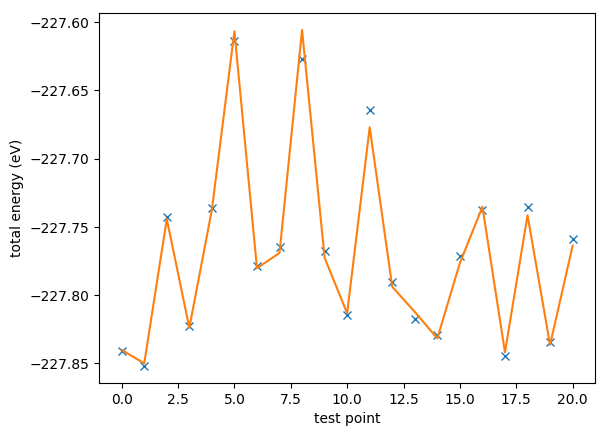

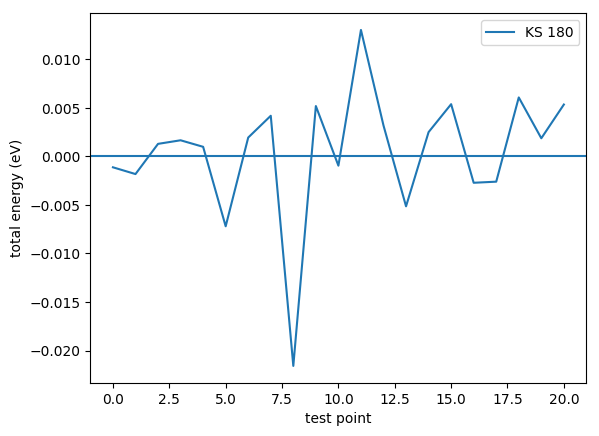

The KRR max error in kcal/mol is 0.5018930284775305
The KRR MAE in kcal/mol is 0.1058603329461513


In [14]:
# return to default and make the fontbigger
plt.rcParams.update(plt.rcParamsDefault)
font = {'size'   : 10}
plt.rc('font', **font)

# choose training set sizes
N = 201
Ms = [5, 7, 10, 15, 75, 133, 180]
input_dim = 12

# choose hyperparameter grids
alphas = np.logspace(-20, -1, 6)
gammas = np.logspace(-2, 1, 100)

for n in range(len(Ms)):
    M = Ms[n]  
    
    # split into test and training
    [train_set, test_set, train_ens, test_ens, train_fours, test_fours] = get_train_test(M, N,input_dim,\
                                                                                         pos, ens, fours)
    
    if M < 10:
        cv = M-1
    else:
        cv = 9

    # fit the model and make plots
    print('\n Current training set size: '+str(M))
    
    [kr, y_kr, errs, MAE, max_err] = fit_KS(train_set, train_ens, \
                                            test_set, test_ens, alphas, \
                                            gammas, cv)
    
    print(kr.best_estimator_)
    
    # plot predictions
    plt.figure()
    plt.plot(y_kr, 'x', label='KS '+str(M))
    plt.plot(test_ens, label='DFT energy')
    plt.xlabel('test point')
    plt.ylabel('total energy (eV)')
    plt.show()
    
    # plot erros
    plt.figure()
    plt.plot(y_kr - test_ens, label='KS '+str(M))
    plt.axhline(0)
    plt.xlabel('test point')
    plt.ylabel('total energy (eV)')
    plt.legend()
    plt.show()
    
    print('The KRR max error in kcal/mol is '+str(max_err / kcal_conv))
    print('The KRR MAE in kcal/mol is '+str(MAE / kcal_conv))

# HK: full grid

In [17]:
# choose training set sizes
N = 201
Ms = [5, 7, 10, 15, 75, 133, 180]
input_dim = 12
comp = 25

for n in range(len(Ms)):
    # choose train size
    M = Ms[n]

    print('\n \n current training set size = '+str(M))

    # split into test and training
    [train_set, test_set, train_ens, test_ens, train_fours, test_fours] = get_train_test(M, N,input_dim,\
                                                                                         pos, ens, fours)

    # fit position to fourier models (i.e. create 15k+ KRR models)
    alpha = 1e-10
    gamma = 1
    krs = pos_to_four(train_set, train_fours, M, alpha, gamma, input_dim, comp)

    # fit fourier to energy model
    alphas = np.logspace(-20, -1, 6)
    gammas = np.logspace(-10, -7, 100)
    [FE_kr, y_kr, errs, MAE, max_err] = four_to_en(train_fours, train_ens, \
                                                   test_fours, test_ens, M, N, alphas, gammas,comp=25)

    print('\n Fourier to energy model:')
    print(FE_kr.best_estimator_)
    print('MAE='+str(MAE/kcal_conv))
    print('error sd = '+str(np.std(np.abs(errs))/kcal_conv))
    print('max error='+str(max_err/kcal_conv))

    # perform double mapping
    [HK_errs, MAE, max_err] = doub_map_fast(test_set, test_ens, krs, FE_kr, M, N, comp=25)

    print('\n Double mapping:')
    print('MAE='+str(MAE / kcal_conv))
    print('max error='+str(max_err/kcal_conv))


 
 current training set size = 5

 Fourier to energy model:
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=1e-10, kernel='rbf',
      kernel_params=None)
MAE=0.8869337031195874
error sd = 0.9337424063286532
max error=6.14867680467553

 Double mapping:
MAE=2.677075884520739
max error=9.907314947893447

 
 current training set size = 7

 Fourier to energy model:
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=8.697490026177834e-09,
      kernel='rbf', kernel_params=None)
MAE=0.6245872353962421
error sd = 0.5703330176602748
max error=2.8445031415392195

 Double mapping:
MAE=2.8138946871116004
max error=15.34177009017875

 
 current training set size = 10

 Fourier to energy model:
KernelRidge(alpha=2.511886431509572e-09, coef0=1, degree=3,
      gamma=7.054802310718631e-09, kernel='rbf', kernel_params=None)
MAE=0.6653816976215625
error sd = 0.6007687882940775
max error=3.3723128834986014

 Double mapping:
MAE=5.599972427529392
max error=32.77355723111052

 
 current training set siz

# HK: reduced grid

In [15]:
# choose training set sizes
N = 201
Ms = [5, 7, 10, 15, 75, 133, 180]
input_dim = 12

for n in range(len(Ms)):
    # choose train size
    M = Ms[n]

    print('\n \n current training set size = '+str(M))

    # split into test and training
    [train_set, test_set, train_ens, test_ens, train_fours, test_fours] = get_train_test(M, N,input_dim,\
                                                                                         pos, ens, fours)
    
    fin = 13
    # only keep significant components
    train_red = train_fours[:,::2,::2,::2]
    test_red = test_fours[:,::2,::2,::2]

    # reduce the box
    train_red = train_red[:,:fin,0:fin,0:fin]
    test_red = test_red[:,:fin,0:fin,0:fin]

    # fit position to fourier models (i.e. create 15k+ KRR models)
    alpha = 1e-10
    gamma = 1
    krs = pos_to_four(train_set, train_red, M, alpha, gamma, input_dim, comp=fin)

    # fit fourier to energy model
    alphas = np.logspace(-20, -1, 6)
    gammas = np.logspace(-10, -7, 100)
    [FE_kr, y_kr, errs, MAE, max_err] = four_to_en(train_red, train_ens, \
                                                   test_red, test_ens, M, N, alphas, gammas,comp=fin)

    print('\n Fourier to energy model:')
    print(FE_kr.best_estimator_)
    print('MAE='+str(MAE/kcal_conv))
    print('error sd = '+str(np.std(np.abs(errs))/kcal_conv))
    print('max error='+str(max_err/kcal_conv))

    # perform double mapping
    [HK_errs, MAE, max_err] = doub_map_fast(test_set, test_ens, krs, FE_kr, M, N, comp=fin)

    print('\n Double mapping:')
    print('MAE='+str(MAE / kcal_conv))
    print('max error='+str(max_err/kcal_conv))


 
 current training set size = 5

 Fourier to energy model:
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=1e-10, kernel='rbf',
      kernel_params=None)
MAE=0.6185724696822287
error sd = 0.593364298912858
max error=4.091991937938538

 Double mapping:
MAE=2.43310945442246
max error=9.090857947032108

 
 current training set size = 7

 Fourier to energy model:
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=1e-10, kernel='rbf',
      kernel_params=None)
MAE=0.970143494758987
error sd = 1.007079487455517
max error=6.668820712934047

 Double mapping:
MAE=3.495017337969545
max error=14.147076264965447

 
 current training set size = 10

 Fourier to energy model:
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=1e-10, kernel='rbf',
      kernel_params=None)
MAE=0.4275029080656425
error sd = 0.46473751039179295
max error=3.7993381050960338

 Double mapping:
MAE=5.539502549046435
max error=30.251405339744544

 
 current training set size = 15

 Fourier to energy model:
KernelRidge(alph

In [9]:
# only keep significant components
train_red = train_fours[:,::2,::2,::2]
test_red = test_fours[:,::2,::2,::2]

# reduce the box
train_red = train_red[:,:fin,0:fin,0:fin]
test_red = test_red[:,:fin,0:fin,0:fin]

In [10]:
train_red.shape

(133, 5, 5, 5)